<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/JACS_bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile, os, cv2
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import MSELoss
import torch.optim as optim
from glob import glob
import imgaug as ia
from imgaug import augmenters as iaa

sns.set_style('darkgrid')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!cp /content/gdrive/MyDrive/bindata.tgz .
!ls

bindata.tgz  datagen  gdrive  sample_data


In [5]:
!tar -zxf bindata.tgz
!ls

bindata.tgz  datagen  gdrive  sample_data


In [6]:
!ls -l datagen/originals/ | wc -l

512


In [7]:
!ls -l datagen/cleaned/ | wc -l

512


# Data Preparation

In [8]:
train_num = int(len(os.listdir('datagen/cleaned/')) * 0.8)
train_num

409

In [9]:
total_noisy_imgs = glob('datagen/originals/*.png')
print(len(total_noisy_imgs))

511


In [10]:
total_cleaned_imgs = glob('datagen/cleaned/*.png')
print(len(total_cleaned_imgs))

511


In [11]:
train_indices = random.sample(range(0, len(total_noisy_imgs)), train_num)
len(train_indices)

409

In [12]:
train_img = []
train_cleaned_img = []
test_img = []
test_cleaned_img = []
for k in range(len(total_noisy_imgs)):
  if k in train_indices:
    train_img.append(total_noisy_imgs[k])
    train_cleaned_img.append(total_cleaned_imgs[k])
  else:
    test_img.append(total_noisy_imgs[k])
    test_cleaned_img.append(total_cleaned_imgs[k])
print(len(train_img), len(train_cleaned_img), len(test_img))

409 409 102


In [13]:
for k in range(5):
  j = random.randint(0, len(train_img))
  print(train_img[j], train_cleaned_img[j])

datagen/originals/4_cubanc_35_1_01281463ta_51.png datagen/cleaned/4_cubanc_35_1_01281463ta_51.png
datagen/originals/6.1_cubanc_35_1_01281463ta_150.png datagen/cleaned/6.1_cubanc_35_1_01281463ta_150.png
datagen/originals/34_cubanc_35_1_01281463ta_111.png datagen/cleaned/34_cubanc_35_1_01281463ta_111.png
datagen/originals/5a.2_cubanc_35_1_01281463ta_69.png datagen/cleaned/5a.2_cubanc_35_1_01281463ta_69.png
datagen/originals/13_cubanc_35_1_01281452ta_34.png datagen/cleaned/13_cubanc_35_1_01281452ta_34.png


In [14]:
train_img[0], train_cleaned_img[0], test_img[0], test_cleaned_img[0]

('datagen/originals/1_cubanc_35_1_01281463ta_164.png',
 'datagen/cleaned/1_cubanc_35_1_01281463ta_164.png',
 'datagen/originals/13_cubanc_35_1_01281463ta_175.png',
 'datagen/cleaned/13_cubanc_35_1_01281463ta_175.png')

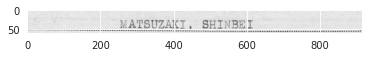

In [15]:
img = cv2.imread(train_img[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

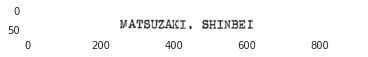

In [16]:
img = cv2.imread(train_cleaned_img[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [17]:
imgs = [cv2.imread(f) for f in train_img]
print('Median Dimensions:', np.median([len(img) for img in imgs]), np.median([len(img[0]) for img in imgs]))
del imgs

Median Dimensions: 72.0 671.0


In [18]:
IMG_SIZE = (32, 300)

In [19]:
def resize_image(image):
    if isinstance(image, str):
      image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    scale_coef = float(IMG_SIZE[0]) / image.shape[0]
    new_width = int(image.shape[1] * scale_coef)

    if new_width > IMG_SIZE[1]:
        # TODO this is a hack
        resized_image = cv2.resize(
            image, (IMG_SIZE[1], IMG_SIZE[0]), cv2.INTER_AREA
        )

        resized_image = resized_image/255.0
        return np.reshape(resized_image, ((*IMG_SIZE, 1)))

    new_height = IMG_SIZE[0]
    resized_image = cv2.resize(image, (new_width, new_height), cv2.INTER_CUBIC)

    padded_image = np.full(IMG_SIZE, np.mean(image), dtype=image.dtype)

    padded_image[
        : resized_image.shape[0], : resized_image.shape[1]
    ] = resized_image

    padded_image = padded_image/255.0
    padded_image = np.reshape(padded_image, (*IMG_SIZE, 1))
    return padded_image

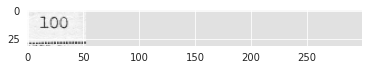

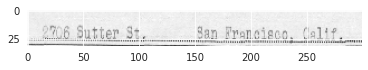

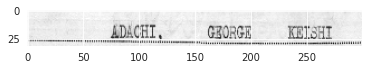

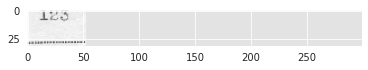

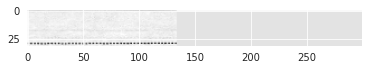

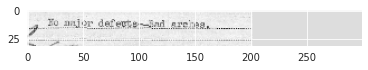

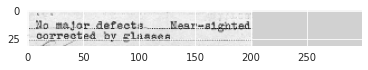

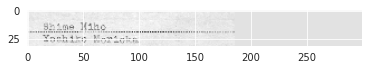

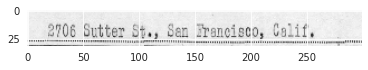

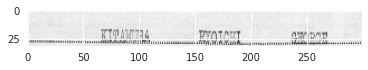

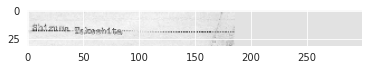

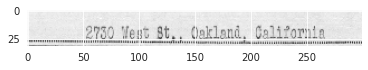

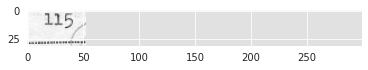

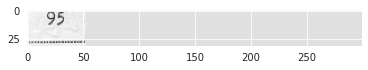

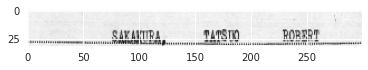

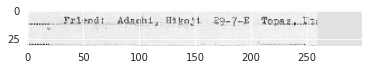

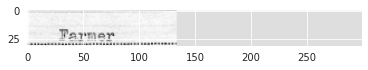

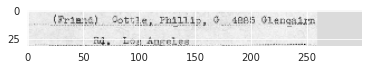

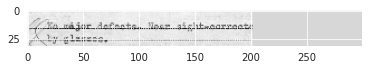

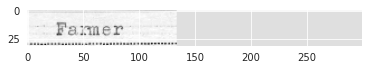

In [20]:
for k in range(20):
  j = random.randint(0, len(train_img))
  img = cv2.imread(train_img[j], cv2.IMREAD_GRAYSCALE)
  img = resize_image(img)
  plt.imshow(img.reshape(*IMG_SIZE), cmap='gray')
  plt.show()

In [21]:
train = []
train_cleaned = []
test = []
test_cleaned = []
for f in train_img:
    train.append(resize_image(f))

for f in train_cleaned_img:
    train_cleaned.append(resize_image(f))
    
for f in test_img:
    test.append(resize_image(f))

for f in test_cleaned_img:
    test_cleaned.append(resize_image(f))
    
train = np.asarray(train)
train_cleaned = np.asarray(train_cleaned)
test = np.asarray(test)
test_cleaned = np.asarray(test_cleaned)

In [22]:
train.shape, train_cleaned.shape, test.shape, test_cleaned.shape

((409, 32, 300, 1), (409, 32, 300, 1), (102, 32, 300, 1), (102, 32, 300, 1))

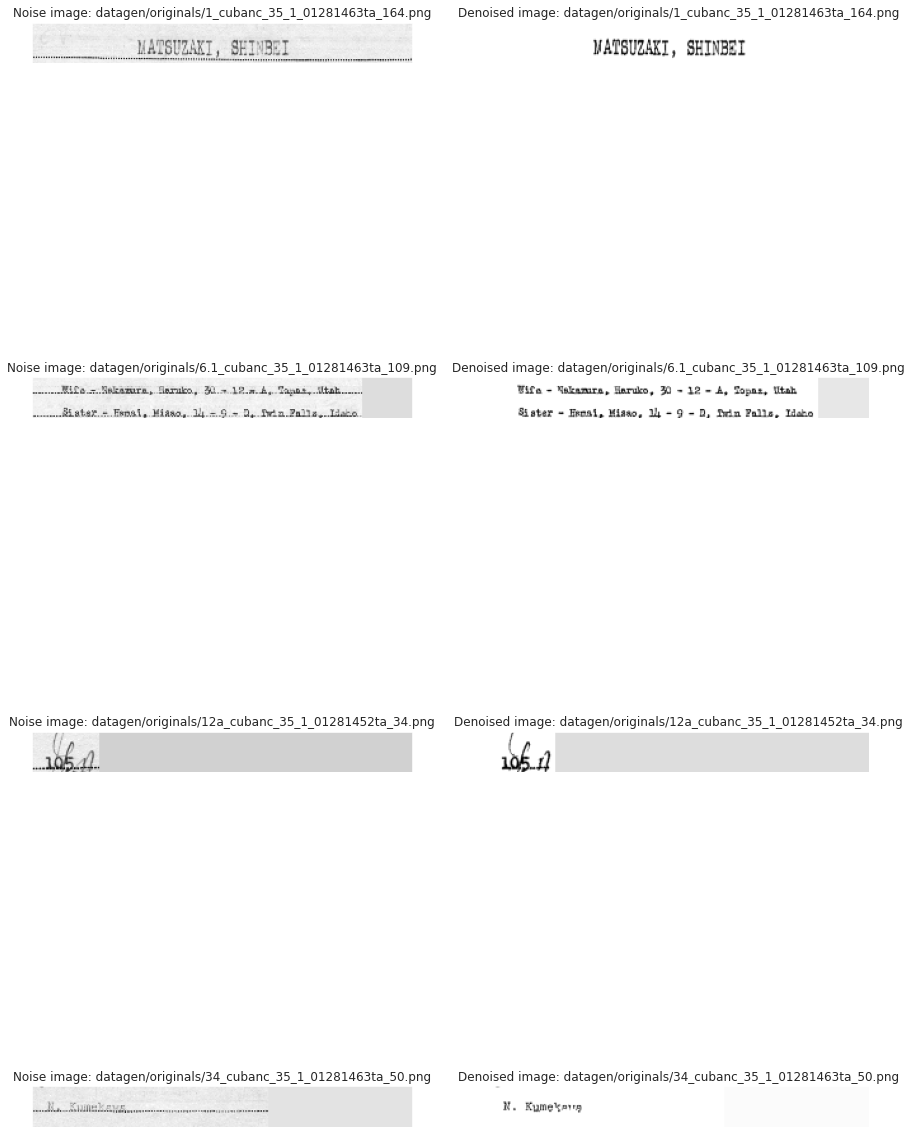

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(15,25))
for i in range(4):
    ax[i][0].imshow(np.squeeze(train[i]), cmap='gray')
    ax[i][0].set_title('Noise image: {}'.format(train_img[i]))
    
    ax[i][1].imshow(np.squeeze(train_cleaned[i]), cmap='gray')
    ax[i][1].set_title('Denoised image: {}'.format(train_img[i]))
    
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)

In [24]:
def augment_pipeline(pipeline, images, seed=53):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

In [25]:
rotate90 = iaa.Rot90(1) # rotate image 90 degrees
rotate180 = iaa.Rot90(2) # rotate image 180 degrees
rotate270 = iaa.Rot90(3) # rotate image 270 degrees
random_rotate = iaa.Rot90((1,3)) # randomly rotate image from 90,180,270 degrees
perc_transform = iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
rotate10 = iaa.Affine(rotate=(10)) # rotate image 10 degrees
rotate10r = iaa.Affine(rotate=(-10)) # rotate image 30 degrees in reverse
crop = iaa.Crop(px=(5, 32)) # Crop between 5 to 32 pixels
hflip = iaa.Fliplr(1) # horizontal flips for 100% of images
vflip = iaa.Flipud(1) # vertical flips for 100% of images
gblur = iaa.GaussianBlur(sigma=(1, 1.5)) # gaussian blur images with a sigma of 1.0 to 1.5
motionblur = iaa.MotionBlur(8) # motion blur images with a kernel size 8

seq_rp = iaa.Sequential([
    iaa.Rot90((1,3)), # randomly rotate image from 90,180,270 degrees
    iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
])

seq_cfg = iaa.Sequential([
    iaa.Crop(px=(5, 32)), # crop images from each side by 5 to 32px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.5)) # blur images with a sigma of 0 to 1.5
])

seq_fm = iaa.Sequential([
    iaa.Flipud(1), # vertical flips all the images
    iaa.MotionBlur(k=6) # motion blur images with a kernel size 6
])

In [26]:
pipeline = [
    rotate90, rotate180, rotate270, hflip, vflip
]

In [27]:
processed_train = augment_pipeline(pipeline, train)
processed_train_cleaned = augment_pipeline(pipeline, train_cleaned)

processed_train.shape, processed_train_cleaned.shape

((2454, 32, 300, 1), (2454, 32, 300, 1))

In [28]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [29]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [30]:
unet = UNet(1, 1)
unet = unet.to(device)

In [31]:
inp = torch.randn((1,1,100,100))

In [32]:
out = unet(inp.to(device))

In [33]:
out.shape

torch.Size([1, 1, 100, 100])

In [34]:
# the images are already numpy arrays, and augmentation has
# already been applied
class DenoiseDS(torch.utils.data.Dataset):
  def __init__(self, images, cleaned_images=None, transforms=None):
    self.images = images
    self.gt = cleaned_images
    self.transforms = transforms

  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    x = self.images[index]
    if self.gt is not None:
      y = self.gt[index]
    else:
      y = None

    # both the input and cleaned image need the same transform
    if self.transforms is not None:
      x = self.transforms(x)
      if y is not None:
        y = self.transforms(y)

    return (x, y)


In [35]:
train_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.GaussianBlur(kernel_size=3),                                 
      transforms.Normalize(mean=0.5, std=0.5)
])

In [36]:
test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=0.5, std=0.5)
])

In [37]:
train_ds = DenoiseDS(images=processed_train, cleaned_images=processed_train_cleaned, transforms=train_transform)
test_ds = DenoiseDS(images=test, cleaned_images=test_cleaned, transforms=test_transform)

In [38]:
train_iter = iter(train_ds)
data = next(train_iter)

In [39]:
x, y = data
type(x), x.shape, y.shape

(torch.Tensor, torch.Size([1, 32, 300]), torch.Size([1, 32, 300]))

In [40]:
criterion = MSELoss(reduction='sum')
optimizer = optim.Adam(unet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

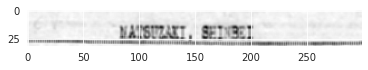

In [41]:
plt.imshow(x.squeeze(0), cmap='gray')

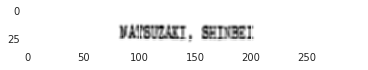

In [42]:
plt.imshow(y.squeeze(0), cmap='gray')

In [43]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=8, shuffle=False)

In [44]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [45]:
num_epochs = 100
early_stopping = EarlyStopping(verbose=True, path="/content/gdrive/MyDrive/BinUNet_v2.pth")

for epoch in range(num_epochs):
  train_losses = []
  valid_losses = []
  unet.train()
  for data in tqdm(train_loader):
    x, y = data

    optimizer.zero_grad()

    x = x.float()
    y = y.float()
    output = unet(x.to(device))

    loss = criterion(output, y.to(device))

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

  epoch_loss = 0.0
  unet.eval()
  for data in tqdm(test_loader):
    x, y = data

    x = x.float()
    y = y.float()

    with torch.no_grad():
      output = unet(x.to(device))

    loss = criterion(output, y.to(device))

    valid_losses.append(loss.item())

  train_loss = np.average(train_losses)
  val_loss = np.average(valid_losses)
  print(f'Epoch {epoch}: train loss {train_loss:.2f}, val loss {val_loss:.2f}')

  scheduler.step(train_loss)
  
  early_stopping(val_loss, unet)

  if early_stopping.early_stop:
    print(f"Early stopping, loading best weight.. , val loss={early_stopping.best_score:.2f}")
    unet.load_state_dict(torch.load(early_stopping.path))
    break


Epoch 0: train loss 3358.21, val loss 2688.67
Validation loss decreased (inf --> 2688.670898).  Saving model ...



Epoch 1: train loss 1735.76, val loss 2345.08
Validation loss decreased (2688.670898 --> 2345.082050).  Saving model ...



Epoch 2: train loss 1509.00, val loss 2079.15
Validation loss decreased (2345.082050 --> 2079.145667).  Saving model ...



Epoch 3: train loss 1295.11, val loss 2040.16
Validation loss decreased (2079.145667 --> 2040.155565).  Saving model ...



Epoch 4: train loss 1093.36, val loss 1853.38
Validation loss decreased (2040.155565 --> 1853.376934).  Saving model ...



Epoch 5: train loss 1006.91, val loss 1797.16
Validation loss decreased (1853.376934 --> 1797.164945).  Saving model ...



Epoch 6: train loss 1015.86, val loss 2022.83
EarlyStopping counter: 1 out of 7



Epoch 7: train loss 947.63, val loss 1939.27
EarlyStopping counter: 2 out of 7



Epoch 8: train loss 895.59, val loss 1861.04
EarlyStopping counter: 3 out of 7



Epoch 9: train loss 881.89, val loss 1680.50
Validation loss decreased (1797.164945 --> 1680.496695).  Saving model ...



Epoch 10: train loss 843.45, val loss 1590.45
Validation loss decreased (1680.496695 --> 1590.447068).  Saving model ...



Epoch 11: train loss 834.60, val loss 1694.76
EarlyStopping counter: 1 out of 7



Epoch 12: train loss 821.84, val loss 1862.76
EarlyStopping counter: 2 out of 7



Epoch 13: train loss 841.75, val loss 1729.56
EarlyStopping counter: 3 out of 7



Epoch 14: train loss 816.33, val loss 1648.55
EarlyStopping counter: 4 out of 7



Epoch 15: train loss 796.16, val loss 1567.41
Validation loss decreased (1590.447068 --> 1567.407302).  Saving model ...



Epoch 16: train loss 781.82, val loss 1429.95
Validation loss decreased (1567.407302 --> 1429.948970).  Saving model ...



Epoch 17: train loss 768.68, val loss 1949.44
EarlyStopping counter: 1 out of 7



Epoch 18: train loss 745.92, val loss 1266.19
Validation loss decreased (1429.948970 --> 1266.192467).  Saving model ...



Epoch 19: train loss 741.08, val loss 1758.93
EarlyStopping counter: 1 out of 7



Epoch 20: train loss 714.38, val loss 1740.51
EarlyStopping counter: 2 out of 7



Epoch 21: train loss 729.29, val loss 2003.04
EarlyStopping counter: 3 out of 7



Epoch 22: train loss 693.19, val loss 1914.44
EarlyStopping counter: 4 out of 7



Epoch 23: train loss 723.87, val loss 1615.42
EarlyStopping counter: 5 out of 7



Epoch 24: train loss 703.08, val loss 1329.95
EarlyStopping counter: 6 out of 7



Epoch 25: train loss 731.15, val loss 1589.97
EarlyStopping counter: 7 out of 7
Early stopping, loading best weight.. , val loss=-1266.19


In [68]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params / 1000000

In [69]:
print(f"Model has {count_parameters(unet):.2f}M parameters")

Model has 17.27M parameters


In [46]:
test_ds = DenoiseDS(images=test, transforms=common_transform)

In [47]:
test_iter = iter(test_ds)

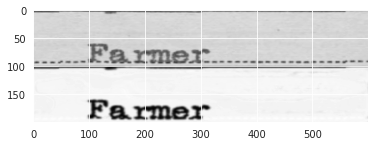

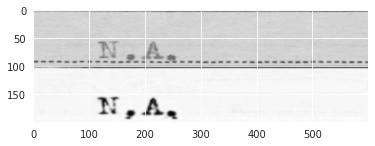

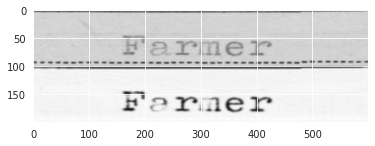

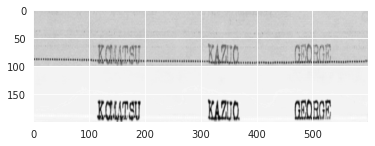

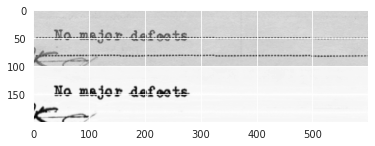

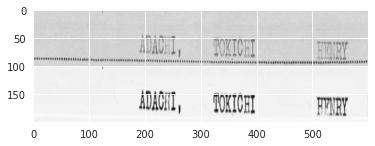

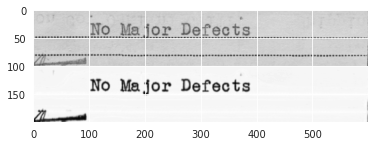

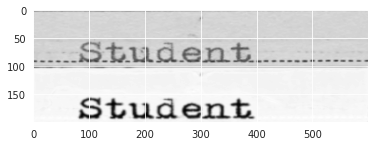

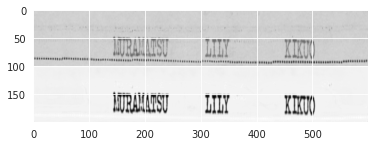

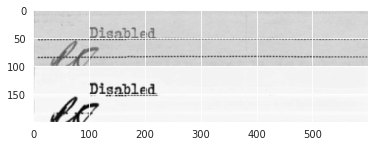

In [70]:
for _ in range(10):
  data = next(test_iter)
  x, _ = data
  
  with torch.no_grad():
    out = unet(x.unsqueeze(0).to(device))

  out = out.cpu()
  d = torch.cat([x.reshape(100, 600), out.reshape(100, 600)], dim=0)
  plt.imshow(d, cmap='gray')
  plt.show()

In [71]:
torch.save(unet.state_dict(), "/content/gdrive/MyDrive/BinUNet.pth")